In [12]:

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from keras.callbacks import TensorBoard
import os
import pickle
from sklearn.model_selection import train_test_split


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

import keras
from keras import layers



In [2]:
def open_pkl(file_name):
    #safe plane timeseg as pickle
    path = os.path.join(os.getcwd(), "dataset2")
    path_file = os.path.join(path, file_name)
    with open(path_file, "rb") as f:
        liste = pickle.load(f)
    return liste

X_vibfeature = open_pkl('X_vibfeature.pickle')
y_defectlabel = open_pkl('y_defectlabel.pickle')
c_context_raw = open_pkl('c_context_raw.pickle')

In [3]:
# convert list to numpy array
X = np.array(X_vibfeature)

# Reshape data into a 2D array
X_vibfeature_2d = X.reshape(X.shape[0], -1)  # (1944, 45, 175) --> (1944, 45*175)
X_vibfeature_2d[0]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on data and transform it
scaled_X_2d = scaler.fit_transform(X_vibfeature_2d)

# Reshape the scaled data back to its original shape
scaled_X = scaled_X_2d.reshape(X.shape)
scaled_X[0]

X_vib = scaled_X

In [4]:
# Convert the nested list into a numpy array
labels_array = np.array(c_context_raw)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert the string label to numerical label
labels_array[:, -1] = label_encoder.fit_transform(labels_array[:, -1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your labels and transform them
c_context_scaled = scaler.fit_transform(labels_array)
c_context_scaled[0]

c_con = c_context_scaled

In [10]:
X_train, X_test, c_train, c_test, y_train, y_test = train_test_split(X_vib, c_con, y_defectlabel, test_size=0.1, random_state=42)


In [6]:
# =========

In [83]:
def create_model():
    # Define the input layer
    inputs = tf.keras.Input(shape=(32, 128, 1))

    # Convolutional and pooling layers with BatchNormalization
    conv1 = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(conv2)

    # Flatten the output from convolutional layers
    flatten = tf.keras.layers.Flatten()(pool2)
    # Dense layer
    dense = tf.keras.layers.Dense(units=512, activation='relu')(flatten)

    # Reshape the dense layer output to match the shape for upsampling
    reshape = tf.keras.layers.Reshape((2, 8, 32))(dense)

    # Upsampling and convolutional layers with BatchNormalization
    conv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(tf.keras.layers.UpSampling2D((2, 2))(reshape)) # pool2
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation('relu')(conv3)

    conv4 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(tf.keras.layers.UpSampling2D((2, 2))(conv3))
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation('relu')(conv4)

    conv5 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(tf.keras.layers.UpSampling2D((4, 4))(conv4))
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Activation('relu')(conv5)

    conv6 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv5)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv6)
    
    return model



# Create the model
model_stride = create_model()
model_stride.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_113 (Conv2D)         (None, 16, 64, 32)        832       
                                                                 
 batch_normalization_18 (Bat  (None, 16, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 16, 64, 32)        0         
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 6, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 6, 22, 32)         924

In [84]:
model_stride.compile(optimizer=optimizer, loss=loss_fn)
model_stride.fit(X_train, X_train, epochs=epochs, validation_split=0.2)#, callbacks=[tensorboard_callback])

Epoch 1/100


2024-03-28 18:18:24.246442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - ETA: 0s - loss: 0.0232

2024-03-28 18:18:29.113683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 6s 95ms/step - loss: 0.0232 - val_loss: 0.0282
Epoch 2/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0121 - val_loss: 0.0177
Epoch 3/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0104 - val_loss: 0.0155
Epoch 4/100
44/44 [==============================] - 2s 49ms/step - loss: 0.0096 - val_loss: 0.0146
Epoch 5/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0090 - val_loss: 0.0146
Epoch 6/100
44/44 [==============================] - 2s 49ms/step - loss: 0.0086 - val_loss: 0.0144
Epoch 7/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0084 - val_loss: 0.0137
Epoch 8/100
44/44 [==============================] - 2s 48ms/step - loss: 0.0081 - val_loss: 0.0135
Epoch 9/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0081 - val_loss: 0.0130
Epoch 10/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0078 - val_loss: 0.0122
Epoch 11/10

7/7 [==============================] - 0s 22ms/step
(195, 32, 128, 1)


/var/folders/ng/jf3w40c95c74vw00ssxmtwq80000gn/T/ipykernel_59641/3218698040.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization


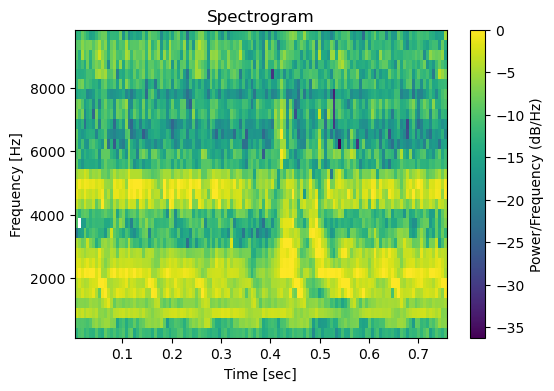

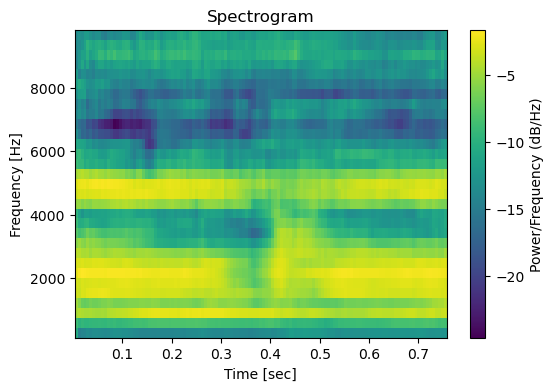

In [88]:
encoded_imgs = model_stride.predict(X_test)
decoded_test = model_stride.predict(encoded_imgs)
print(decoded_test.shape)
decoded_test = decoded_test.reshape(195, 32, 128)

i = 4
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

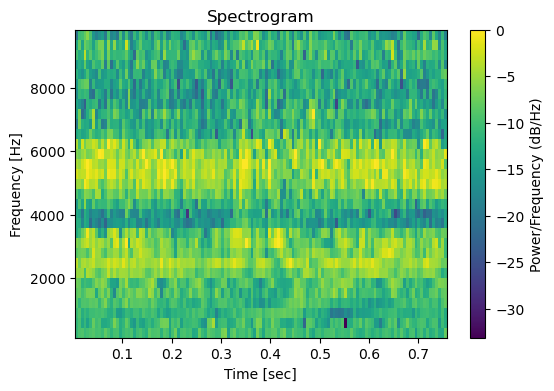

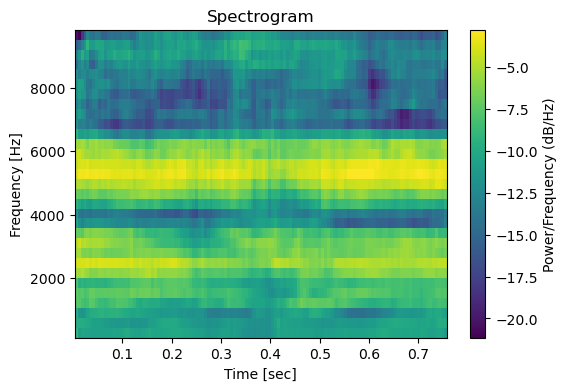

In [97]:
i = 57
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

In [62]:
def create_model():
    # Define the input layer
    inputs = tf.keras.Input(shape=(32, 128, 1))

    # Convolutional and pooling layers
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2)

    # Flatten the output from convolutional layers
    flatten = tf.keras.layers.Flatten()(pool2)
    # Dense layer
    dense = tf.keras.layers.Dense(units=8192, activation='relu')(flatten)

    dense = tf.keras.layers.Dense(units=8192/8, activation='relu')(dense)



    #decode...
    dense = tf.keras.layers.Dense(units=8192, activation='relu')(dense)

    reshape = tf.keras.layers.Reshape((8, 32, 32))(dense)


    # Upsampling and convolutional layers
    conv3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(reshape))#pool2
    conv4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(conv3))
    conv5 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv5)
    
    return model

# Create the model
model_8dense = create_model()
model_8dense.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 64, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 8, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0   

In [66]:
def create_model():
    # Define the input layer
    inputs = tf.keras.Input(shape=(32, 128, 1))

    # Convolutional and pooling layers
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2)
    conv2a = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)

    # Flatten the output from convolutional layers
    flatten = tf.keras.layers.Flatten()(conv2a)
    # Dense layer
    dense = tf.keras.layers.Dense(units=8192, activation='relu')(flatten)

    reshape = tf.keras.layers.Reshape((8, 32, 32))(dense)


    # Upsampling and convolutional layers
    conv3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(reshape))#pool2
    conv4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(conv3))
    conv5 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv5)
    
    return model

# Create the model
model_1dense = create_model()
model_1dense.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 64, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 8, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 8, 32, 32)         9248

In [58]:
# Define loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model_1dense.compile(optimizer=optimizer, loss=loss_fn)

# Train the model
epochs = 100

model_1dense.fit(X_train, X_train, epochs=epochs, validation_split=0.2)#, callbacks=[tensorboard_callback])

Epoch 1/100


2024-03-27 23:47:46.429541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - ETA: 0s - loss: 0.0351

2024-03-27 23:47:50.041982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 5s 80ms/step - loss: 0.0351 - val_loss: 0.0245
Epoch 2/100
44/44 [==============================] - 3s 66ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 3/100
44/44 [==============================] - 3s 61ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 4/100
44/44 [==============================] - 3s 60ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 5/100
44/44 [==============================] - 3s 60ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 6/100
44/44 [==============================] - 3s 65ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 7/100
44/44 [==============================] - 3s 67ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 8/100
44/44 [==============================] - 3s 64ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 9/100
44/44 [==============================] - 3s 62ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 10/100
44/44 [==============================] - 3s 65ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 11/10

2024-03-28 00:09:40.119912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/7 [====================>.........] - ETA: 0s

2024-03-28 00:09:40.586695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 23ms/step
(195, 32, 128, 1)


/var/folders/ng/jf3w40c95c74vw00ssxmtwq80000gn/T/ipykernel_59641/3218698040.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization


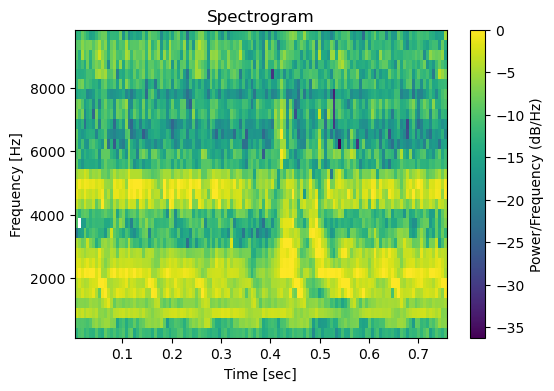

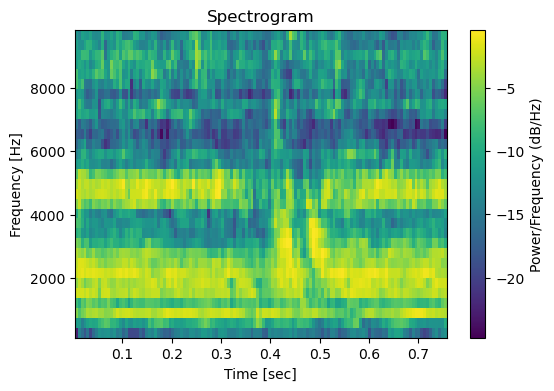

In [61]:
encoded_imgs = model_1dense.predict(X_test)
decoded_test = model_1dense.predict(encoded_imgs)
print(decoded_test.shape)
decoded_test = decoded_test.reshape(195, 32, 128)

i = 4
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

In [41]:
# Define the input layer
inputs = tf.keras.Input(shape=(32, 128, 1))

# Define the convolutional layers
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2)

# Flatten the output from convolutional layers
#flatten = tf.keras.layers.Flatten()(pool2)

# Dense layer
#dense = tf.keras.layers.Dense(units=8192, activation='relu')(flatten)

# Upsampling and convolutional layers
conv3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(dense)) #dense
conv4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(conv3))
conv5 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv5)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 64, 32)        9248      
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 32, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 128, 32)       9248

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),



    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 64, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 32, 32)        0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 32, 32)         9248      
                                                                 
 up_sampling2d_6 (UpSampling  (None, 16, 64, 32)      

In [67]:
# Define loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model_8dense.compile(optimizer=optimizer, loss=loss_fn)

# Train the model
epochs = 100

model_8dense.fit(X_train, X_train, epochs=epochs, validation_split=0.2)#, callbacks=[tensorboard_callback])

Epoch 1/100


2024-03-28 00:26:11.788104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - ETA: 0s - loss: 0.0257

2024-03-28 00:26:15.625716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 5s 85ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 2/100
44/44 [==============================] - 3s 68ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 3/100
44/44 [==============================] - 3s 70ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 4/100
44/44 [==============================] - 3s 68ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 5/100
44/44 [==============================] - 3s 66ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 6/100
44/44 [==============================] - 3s 73ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 7/100
44/44 [==============================] - 3s 67ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 8/100
44/44 [==============================] - 4s 84ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 9/100
44/44 [==============================] - 3s 70ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 10/100
44/44 [==============================] - 3s 65ms/step - loss: 0.0257 - val_loss: 0.0245
Epoch 11/10

1/7 [===>..........................] - ETA: 1s

2024-03-28 00:31:07.547632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/7 [===>..........................] - ETA: 1s

2024-03-28 00:31:07.958270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 31ms/step
(195, 32, 128, 1)


/var/folders/ng/jf3w40c95c74vw00ssxmtwq80000gn/T/ipykernel_59641/3218698040.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization


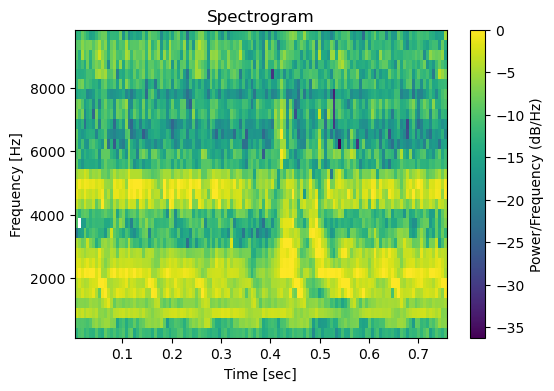

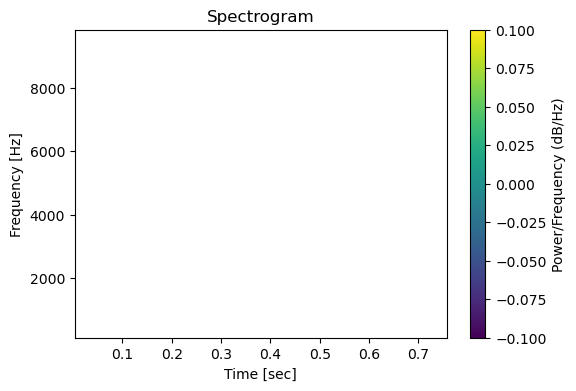

In [68]:
encoded_imgs = model_8dense.predict(X_test)
decoded_test = model_8dense.predict(encoded_imgs)
print(decoded_test.shape)
decoded_test = decoded_test.reshape(195, 32, 128)

i = 4
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

In [65]:
decoded_test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [59]:
decoded_test[i]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

2024-03-27 22:54:25.644526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/7 [================>.............] - ETA: 0s

2024-03-27 22:54:26.339505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 28ms/step
(195, 32, 128, 1)


/var/folders/ng/jf3w40c95c74vw00ssxmtwq80000gn/T/ipykernel_59641/3218698040.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization


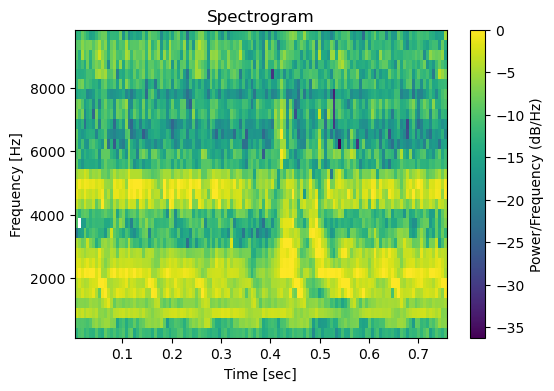

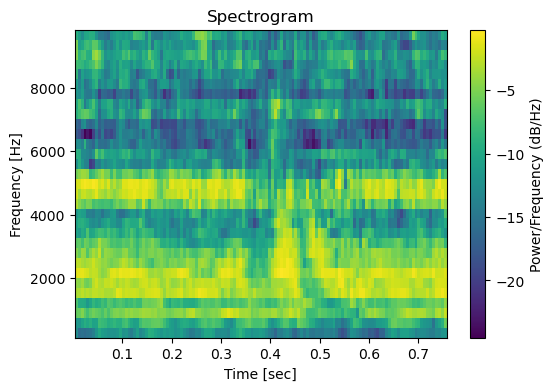

In [49]:
encoded_imgs = model.predict(X_test)
decoded_test = model.predict(encoded_imgs)
print(decoded_test.shape)
decoded_test = decoded_test.reshape(195, 32, 128)

i = 4
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

In [22]:
import matplotlib.pyplot as plt

def plot_spectrogram(f, t, Sxx):
    """
    Plot Spectrogram using Matplotlib.

    Parameters:
    - f: 1-D array_like, Array of sample frequencies.
    - t: 1-D array_like, Array of time points.
    - Sxx: 2-D array_like, Spectrogram of x. Columns are the periodograms of consecutive segments.

    Returns:
    - None (displays the plot)
    """
    plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.title('Spectrogram')
    plt.rcParams["figure.figsize"]=(12 * 0.5, 8 * 0.5)
    plt.show()

f = np.array([117.43119266,  430.58103976,  743.73088685, 1056.88073394,
       1370.03058104, 1683.18042813, 1996.33027523, 2309.48012232,
       2622.62996942, 2935.77981651, 3248.92966361, 3562.0795107 ,
       3875.2293578 , 4188.37920489, 4501.52905199, 4814.67889908,
       5127.82874618, 5440.97859327, 5754.12844037, 6067.27828746,
       6380.42813456, 6693.57798165, 7006.72782875, 7319.87767584,
       7633.02752294, 7946.17737003, 8259.32721713, 8572.47706422,
       8885.62691131, 9198.77675841, 9511.9266055 , 9825.0764526 ])

t = np.array([0.00338867, 0.00932617, 0.01526367, 0.02120117, 0.02713867,
       0.03307617, 0.03901367, 0.04495117, 0.05088867, 0.05682617,
       0.06276367, 0.06870117, 0.07463867, 0.08057617, 0.08651367,
       0.09245117, 0.09838867, 0.10432617, 0.11026367, 0.11620117,
       0.12213867, 0.12807617, 0.13401367, 0.13995117, 0.14588867,
       0.15182617, 0.15776367, 0.16370117, 0.16963867, 0.17557617,
       0.18151367, 0.18745117, 0.19338867, 0.19932617, 0.20526367,
       0.21120117, 0.21713867, 0.22307617, 0.22901367, 0.23495117,
       0.24088867, 0.24682617, 0.25276367, 0.25870117, 0.26463867,
       0.27057617, 0.27651367, 0.28245117, 0.28838867, 0.29432617,
       0.30026367, 0.30620117, 0.31213867, 0.31807617, 0.32401367,
       0.32995117, 0.33588867, 0.34182617, 0.34776367, 0.35370117,
       0.35963867, 0.36557617, 0.37151367, 0.37745117, 0.38338867,
       0.38932617, 0.39526367, 0.40120117, 0.40713867, 0.41307617,
       0.41901367, 0.42495117, 0.43088867, 0.43682617, 0.44276367,
       0.44870117, 0.45463867, 0.46057617, 0.46651367, 0.47245117,
       0.47838867, 0.48432617, 0.49026367, 0.49620117, 0.50213867,
       0.50807617, 0.51401367, 0.51995117, 0.52588867, 0.53182617,
       0.53776367, 0.54370117, 0.54963867, 0.55557617, 0.56151367,
       0.56745117, 0.57338867, 0.57932617, 0.58526367, 0.59120117,
       0.59713867, 0.60307617, 0.60901367, 0.61495117, 0.62088867,
       0.62682617, 0.63276367, 0.63870117, 0.64463867, 0.65057617,
       0.65651367, 0.66245117, 0.66838867, 0.67432617, 0.68026367,
       0.68620117, 0.69213867, 0.69807617, 0.70401367, 0.70995117,
       0.71588867, 0.72182617, 0.72776367, 0.73370117, 0.73963867,
       0.74557617, 0.75151367, 0.75745117])

In [23]:
encoded_imgs = model.predict(X_train)
decoded_imgs = model.predict(encoded_imgs)
print(decoded_imgs.shape)
decoded_imgs = decoded_imgs.reshape(1749, 32, 128)


55/55 [==============================] - 1s 12ms/step
(1749, 32, 128, 1)


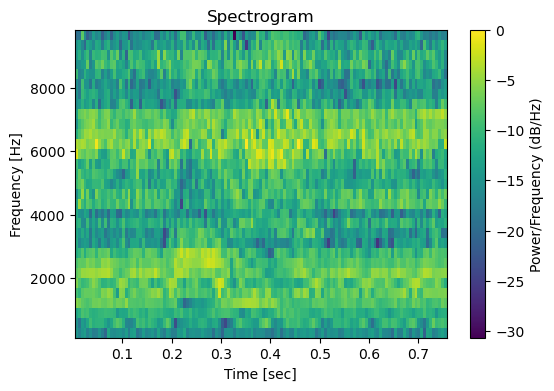

In [25]:
plot_spectrogram(f, t, X_train[8])

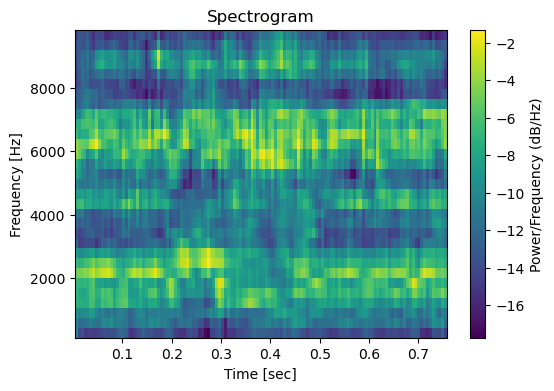

In [26]:
plot_spectrogram(f, t, decoded_imgs[8])

In [28]:
encoded_imgs = model.predict(X_test)
decoded_test = model.predict(encoded_imgs)
print(decoded_test.shape)
decoded_test = decoded_test.reshape(195, 32, 128)

7/7 [==============================] - 0s 15ms/step
(195, 32, 128, 1)


/var/folders/ng/jf3w40c95c74vw00ssxmtwq80000gn/T/ipykernel_59641/3218698040.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx[:-1, :-1]), shading = 'flat')  # Using log scale for better visualization


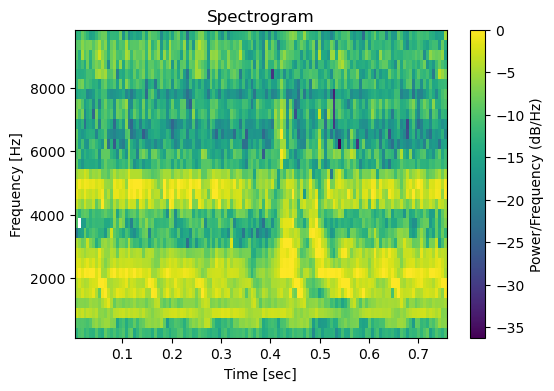

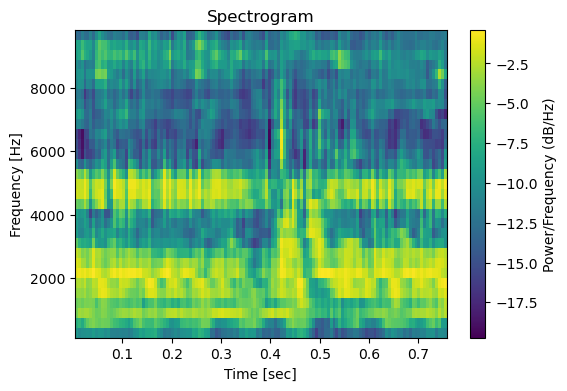

In [34]:
i = 4
plot_spectrogram(f, t, X_test[i])
plot_spectrogram(f, t, decoded_test[i])

# ===============

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

model.summary()